In [1]:
import pandas as pd
import json
from pathlib import Path

In [2]:
source_csv_dir = Path("/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986")
data_dir = ("/home/heh/datasets/slurp-speechbrain")

csv_list = list(source_csv_dir.glob("*.csv"))
print(csv_list)

[PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/train-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/train_synthetic-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/train_real-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/devel-type=direct.csv'), PosixPath('/home/heh/github/speechbrain/recipes/SLURP/direct/results/1986/test-type=direct.csv')]


In [1]:
import json
def load_manifest(filepath):
    data = []
    with open(filepath, "r") as fin:
        for line in fin.readlines():
            datum = json.loads(line)
            data.append(datum)

    return data

In [16]:
train1 = "../manifests/train_real_asr.json"
train2 = "../manifests/train_synthetic_asr.json"
data1 = load_manifest(train1) 
data2 = load_manifest(train2)
data = data1 + data2
durations1 = [d["duration"] for d in data1]
durations2 = [d["duration"] for d in data2]
durations = [d["duration"] for d in data]
print(len(data1), "samples")
print(f"{sum(durations1) / 3600} hours")
print(len(data2), "samples")
print(f"{sum(durations2) / 3600} hours")
print(len(data), "samples")
print(f"{sum(durations) / 3600} hours")

50628 samples
40.22760474722184 hours
69253 samples
44.442141661110725 hours
119881 samples
84.66974640833308 hours


In [8]:
filepath = "../manifests/dev_asr.json"
data = load_manifest(filepath)
durations = [d["duration"] for d in data]
print(len(data), "samples")
print(f"{sum(durations) / 3600} hours")

8690 samples
6.902020319444427 hours


In [9]:
filepath = "../manifests/test_asr.json"
data = load_manifest(filepath)
durations = [d["duration"] for d in data]
print(len(data), "samples")
print(f"{sum(durations) / 3600} hours")

13078 samples
10.253316301110935 hours


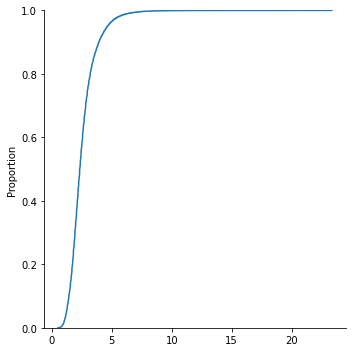

In [6]:
import seaborn as sns
sns.displot(durations, kind="ecdf")

In [13]:
print(data[10:11])
corpus = [d["text"] for d in data]

[{'id': '10', 'slurp_id': '7874', 'audio_filepath': 'wavs/slurp_real/audio-1490262086-headset.wav', 'text': 'i need an event three days from now scheduled with amy', 'semantics': {'scenario': 'calendar', 'action': 'set', 'entities': [{'type': 'date', 'filler': 'three days from now'}, {'type': 'person', 'filler': 'amy'}]}, 'duration': 3.328}]


In [15]:
vocabulary = sorted(set(" ".join(corpus).split()))
print(len(vocabulary))

6715


# Generate BIO Annotation for NLU

In [2]:
from pathlib import Path
output_dir = Path('../manifests_nlu_bio2')
output_dir.mkdir(exist_ok=True, parents=True)

train_file1 = '../manifests_nlu_cleaned/train_real_nlu_oracle.json'
train_file2 = '../manifests_nlu_cleaned/train_synth_nlu_oracle.json'

train_data = load_manifest(train_file1) + load_manifest(train_file2)
print(len(train_data))
# get intent and slot mapping

def dump_dict_csv(data, filepath):
    with Path(filepath).open("w") as fout:
        for d in data:
            fout.write(f"{d}\n")

all_intents = set()
all_slots = set()
for datum in train_data:
    datum = datum["semantics"]
    intent = f"{datum['scenario']}_{datum['action']}"
    all_intents.add(intent)
    for entity in datum['entities']:
        slot = entity["type"]
        all_slots.add(f"B-{slot}")
        all_slots.add(f"I-{slot}")

all_intents = ["UNK"] + sorted(list(all_intents)) 
all_slots = sorted(list(all_slots)) + ["O"]

output_intents = output_dir / Path("dict.intents.csv")
output_slots = output_dir / Path("dict.slots.csv")

dump_dict_csv(all_intents, output_intents)
dump_dict_csv(all_slots, output_slots)


119842


In [3]:
print(len(all_intents), len(all_slots))

70 113


In [11]:

def sentence_to_bio(sentence: str, entities: list):
    anno = {}
    words = sentence.lower().split()
    for entity in entities:
        slot = entity["type"]
        fillers = entity["filler"].lower().split()
        try:
            start_idx = words.index(fillers[0])
        except:
            print(sentence)
            print(entities)
            raise ValueError(f"filler {fillers[0]} not found in text: {sentence}")
        
        anno[start_idx] = f"B-{slot}"
        for idx in range(start_idx + 1, start_idx + len(fillers)):
            anno[idx] = f"I-{slot}"
    
    bios = []
    for i in range(len(words)):
        if i in anno:
            bios.append(anno[i])
        else:
            bios.append("O")
    return bios

def str2idx(src, mapping):
    return " ".join([str(mapping.index(s)) for s in src])


def convert_to_bio_format(data, split, text_key="text", parse_slots=True):
    out_file = output_dir / Path(f"{split}.tsv")
    out_file_slots = output_dir / Path(f"{split}_slots.tsv")
    out_file_slots_raw = output_dir / Path(f"{split}_slots_raw.tsv")
    text = []
    intents = []
    slots = []
    slots_raw = []
    for datum in data:
        text.append(datum[text_key])
        semantics = datum["semantics"]
        intent_i = f"{semantics['scenario']}_{semantics['action']}"
        intents.append(all_intents.index(intent_i))
        if parse_slots:
            bio_slots = sentence_to_bio(datum[text_key], semantics["entities"])
            slots_raw.append(" ".join(bio_slots))
            slots.append(str2idx(bio_slots, all_slots))

    with out_file.open("w") as fout:
        fout.write(f"sentence\tintent\n")
        for i in range(len(text)):
            if len(text[i].split()) == 0:
                text[i] = "emtpy sentence"
            fout.write(f"{text[i]}\t{intents[i]}\n")

    if parse_slots:
        with out_file_slots.open("w") as fout:
            for i in range(len(text)):
                fout.write(f"{slots[i]}\n")
        with out_file_slots_raw.open("w") as fout:
            for i in range(len(text)):
                fout.write(f"{slots_raw[i]}\n")
        
        

In [5]:
dev_input = Path("../manifests_nlu_cleaned/dev_nlu_oracle.json")
dev_data = load_manifest(dev_input)
convert_to_bio_format(dev_data, "dev", "text")

In [13]:
dev_input = Path("../manifests_nlu_cleaned/test_nlu_ft.json")
dev_data = load_manifest(dev_input)
convert_to_bio_format(dev_data, "test", "pred_text", parse_slots=False)

In [8]:
train_input1 = Path("../manifests_nlu_cleaned/train_real_nlu_oracle.json")
train_input2 = Path("../manifests_nlu_cleaned/train_synth_nlu_oracle.json")
train_data = load_manifest(train_input1) + load_manifest(train_input2)
convert_to_bio_format(train_data, "train", "text")